## 0. Import Packages

In [45]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import json
import cv2
import sys
import tarfile
import glob

import random
import shutil
import imageio
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from keras.models import Model

import keras
from keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB4
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetB3
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

import numpy as np
import pandas as pd
from matplotlib import pyplot
from numpy import expand_dims
import matplotlib.pyplot as plt

## 1. Explore and Visualize dataset

In [46]:
BASE_DIR = os.getcwd()
with open(os.path.join(BASE_DIR, "label_num_to_disease_map.json")) as file:
    map_classes = json.loads(file.read())
    map_classes = {int(k) : v for k, v in map_classes.items()}
    
print(json.dumps(map_classes, indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [47]:
input_files = os.listdir(os.path.join(BASE_DIR, "train_images"))
print(f"Number of train images: {len(input_files)}")

Number of train images: 21397


In [48]:
img_shapes = {}
for image_name in os.listdir(os.path.join(BASE_DIR, "train_images"))[:300]:
    image = cv2.imread(os.path.join(BASE_DIR, "train_images", image_name))
    img_shapes[image.shape] = img_shapes.get(image.shape, 0) + 1

print(img_shapes)

{(600, 800, 3): 300}


In [49]:
df_train = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))
df_train["class_name"] = df_train["label"].map(map_classes)
df_train

,image_id,label,class_name
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)
...,...,...,...
21392,999068805.jpg,3,Cassava Mosaic Disease (CMD)
21393,999329392.jpg,3,Cassava Mosaic Disease (CMD)
21394,999474432.jpg,1,Cassava Brown Streak Disease (CBSD)
21395,999616605.jpg,4,Healthy


In [50]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 20))
    
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(1, 4, ind + 1)
        image = cv2.imread(os.path.join(BASE_DIR, "train_images", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
    plt.show()

In [51]:
tmp_df0 = df_train[df_train["label"] == 0]
print(f"Total train images for class 0: {tmp_df0.shape[0]}")
tmp_df1 = df_train[df_train["label"] == 1]
print(f"Total train images for class 1: {tmp_df1.shape[0]}")
tmp_df2 = df_train[df_train["label"] == 2]
print(f"Total train images for class 2: {tmp_df2.shape[0]}")
tmp_df3 = df_train[df_train["label"] == 3]
print(f"Total train images for class 3: {tmp_df3.shape[0]}")
tmp_df4 = df_train[df_train["label"] == 4]
print(f"Total train images for class 4: {tmp_df4.shape[0]}")

Total train images for class 0: 1087
Total train images for class 1: 2189
Total train images for class 2: 2386
Total train images for class 3: 13158
Total train images for class 4: 2577


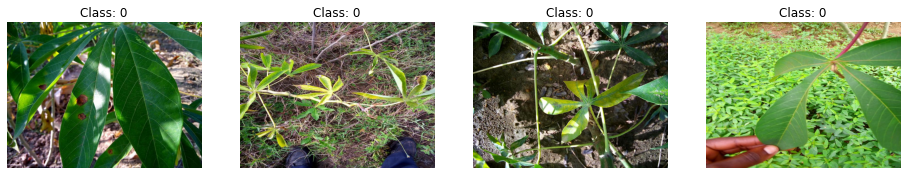

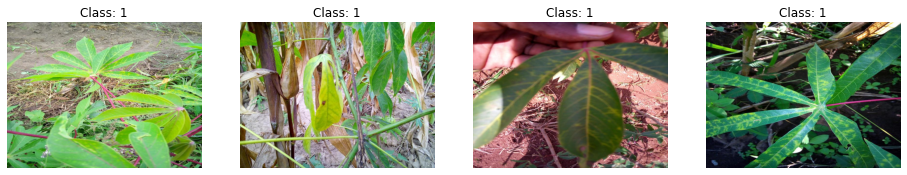

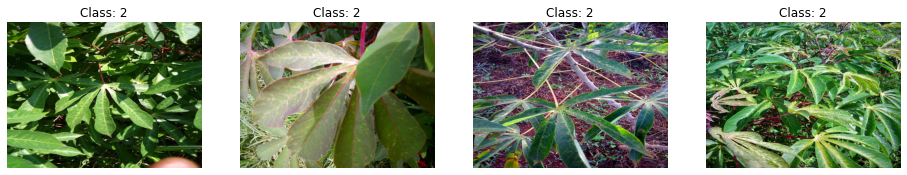

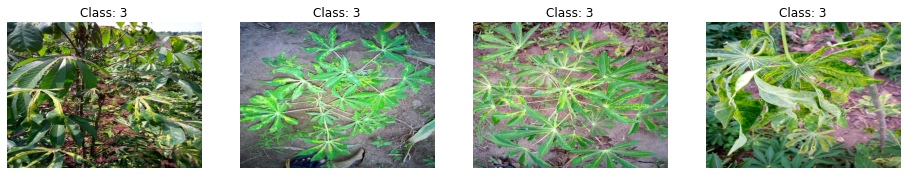

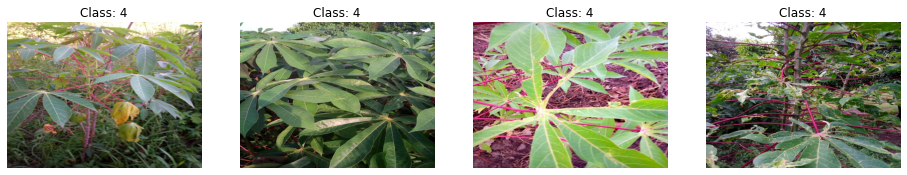

In [52]:
# visualization
for i in range(5):
    tmp_df = globals()['tmp_df{}'.format(i)].sample(4)
    image_ids = tmp_df["image_id"].values
    labels = tmp_df["label"].values

    visualize_batch(image_ids, labels)

## 2. Data Preprocessing

In [55]:
def read_image(image_id , label):
    plt.figure(figsize=(15, 10))
    image = cv2.imread(os.path.join(BASE_DIR, "train_images", image_id))
    
    return image

def create_masks(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

def segment_image(image):
    mask = create_masks(image)
    output = cv2.bitwise_and(image, image, mask=mask)
    return output/255


<Figure size 1080x720 with 0 Axes>

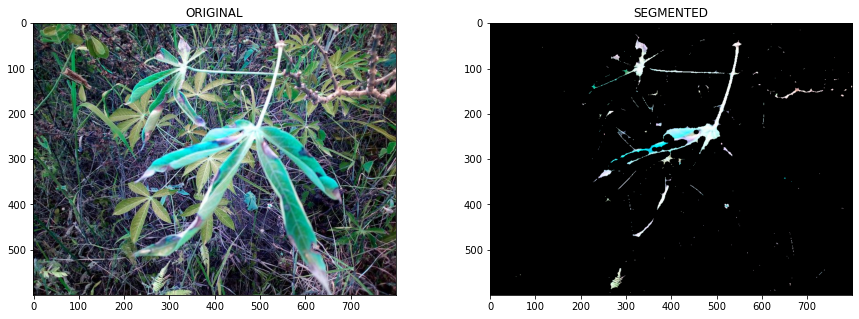

<Figure size 1080x720 with 0 Axes>

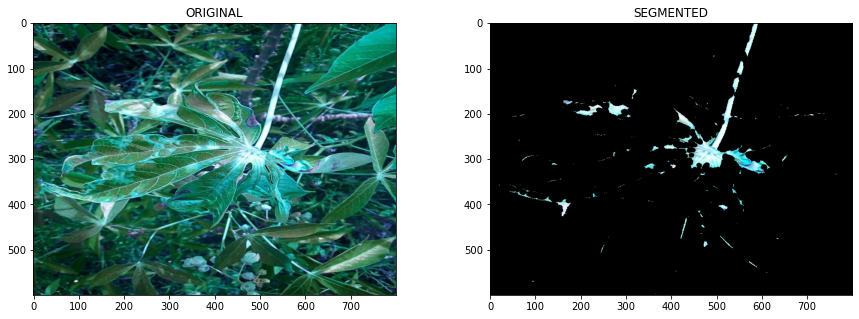

<Figure size 1080x720 with 0 Axes>

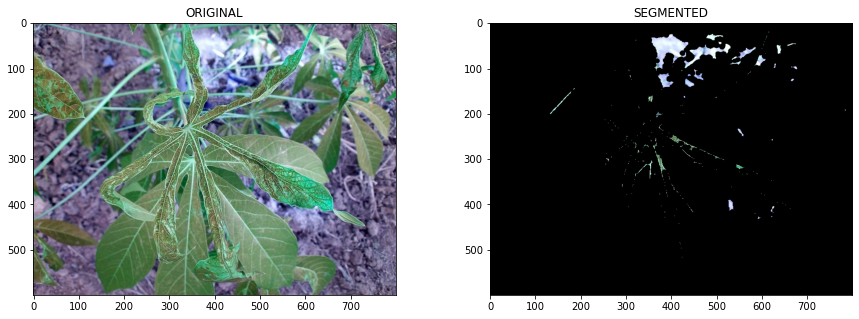

<Figure size 1080x720 with 0 Axes>

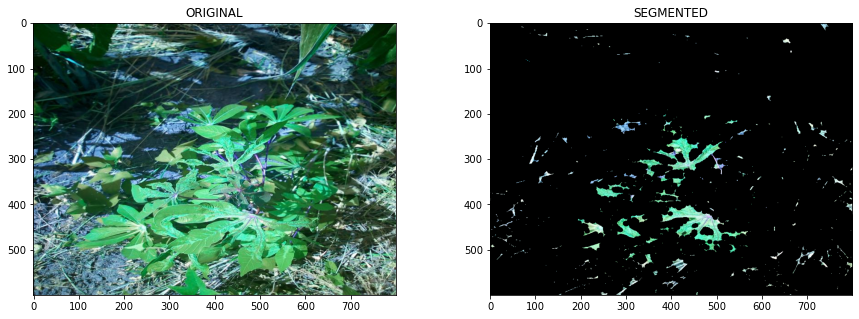

<Figure size 1080x720 with 0 Axes>

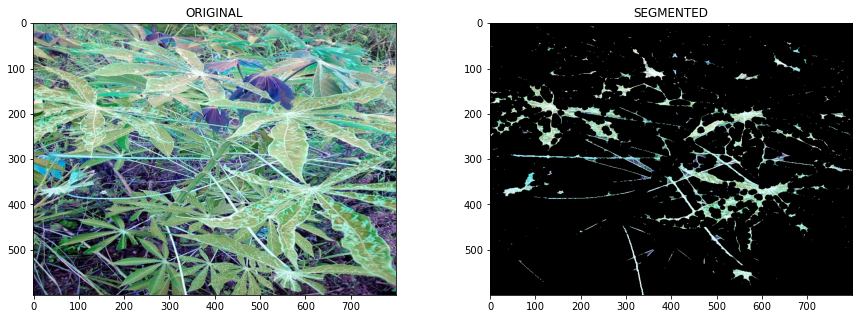

In [70]:
for i in range(5):
    image = read_image(df_train['image_id'][i+1000],(255,255))

    #segmentation
    image_segmented = segment_image(image)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5));
    ax[0].set_title('ORIGINAL', fontsize=12)
    ax[1].set_title('SEGMENTED', fontsize=12)

    ax[0].imshow(image/255);
    ax[1].imshow(image_segmented);
    plt.savefig('fig/'+str(i)+'.jpg')

## 3. Training - EfficientNetB4

In [24]:
train_labels = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))

# parameters
batch_size = 128
steps_per_epoch = len(train_labels)*0.8 / batch_size
validation_steps = len(train_labels)*0.2 / batch_size
epochs = 10
target_size = 260 ##
num_classes = 5

In [31]:
train_labels.label = train_labels.label.astype('str')

train_datagen = ImageDataGenerator(validation_split = 0.2,
                                   rescale = 1./255,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   shear_range = 0.1)

train_generator = train_datagen.flow_from_dataframe(train_labels,
                         directory = os.path.join(BASE_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (target_size, target_size),
                         batch_size = batch_size,
                         color_mode = 'grayscale',
                         class_mode = "categorical")


validation_datagen = ImageDataGenerator(validation_split = 0.2, rescale = 1./255)

validation_generator = validation_datagen.flow_from_dataframe(train_labels,
                         directory = os.path.join(BASE_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (target_size, target_size),
                         batch_size = batch_size,
                         color_mode = 'grayscale',
                         class_mode = "categorical")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


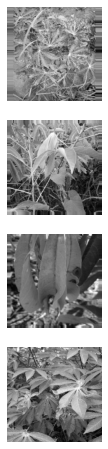

In [73]:
x_batch, y_batch = next(train_generator)

fig = plt.figure(figsize=(8, 8))
for i in range(4):
    image = x_batch[i]
    image = image.reshape(260, 260)
    ax = fig.add_subplot(4, 4, 4*i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.savefig('fig/all.jpg')    
plt.show()

In [33]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

In [38]:
model = Sequential()
optimizer = Adam(lr=0.00105)

b4model = EfficientNetB4(include_top = False, 
                          weights = None, 
                          pooling='avg')

model.add(b4model)
model.add(Dense(5, activation ='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 8965      
Total params: 17,682,788
Trainable params: 17,557,581
Non-trainable params: 125,207
_________________________________________________________________


In [39]:
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [40]:
%%time
hist10 = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=[early_stopping, mc],
    verbose = 1)

In [41]:
loaded_model = load_model('best_model.h5')

In [ ]:
def plot_accuracy_and_loss(hist):
    plt.figure(1, figsize= (15, 10))

    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Baseline CNN Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Baseline CNN loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.show()

In [ ]:
from sklearn.metrics import classification_report

pred_valid_y = loaded_model.predict(validation_generator,  verbose = True)
pred_valid_y_labels = np.argmax(pred_valid_y, axis=-1)
valid_labels = validation_generator.labels

print(classification_report(valid_labels, pred_valid_y_labels ))